# How to normalize spectrograms
> Scaling spectrograms for neural networks. 

- toc: true 
- badges: true
- comments: true
- categories: [deep learning, spectrogram normalizations]
- image: images/violin_spec.png

In [ ]:
#| default_exp normalizingSpectrogramsPost

# **NOTE: under heavy construction**

# Introduction  

Spectrograms are often used as images to train deep neural networks for audio tasks. By treating spectrograms as images, we can borrow from the many powerful ideas in image recognition with deep learning. A spectrogram, however, is fundamentally different than natural images as we will see below. That brings up the central question of this post: how should spectrograms be normalized during training?  

This post assumes some familiarity with deep learning and signal processing concepts like the FFT. It is also a light introduction to the [fastaudio](https://github.com/fastaudio/fastaudio) library.

In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np

# Transforming audio into two dimensions

Image classification is a challenging task that was previously done with expert, handcrafted features. Now, features are automatically learned from labeled data instead. The success of these learned features has completely  shifted the paradigm of Computer Vision. We would ideally like to apply these same, proven techniques on audio tasks.  

However, audio is treated like a one dimensional signal in most Machine Learning applications. That means raw audio is unusable with 2-D Convolutional Neural Networks (CNNs), which are the workhorses of modern image recognition. If we could somehow represent audio in two dimensions, like an image, then we could leverage the successful approaches in image classification.  

Thankfully there are many ways of transforming audio into two dimensions. The most popular one is turning audio into a [spectrogram](https://ccrma.stanford.edu/~jos/mdft/Spectrograms.html). As an example, the image below shows the spectrogram of this [violin recording](https://upload.wikimedia.org/wikipedia/commons/d/d1/Violin_for_spectrogram.ogg) taken from Wikipedia.  

![The spectrogram of a violin recording](images/violin_spec.png "Spectrogram of a violing recording.")  

The spectrogram is a 2-D signal representation in time and frequency, so we can use it with 2-D CNNs! But first it is crucial to preprocess and normalize the spectrograms. Neural networks have a much easier time learning when their inputs are normalized.  

For natural images, normalization uses an estimated mean ($\mu$) and standard deviation ($\sigma$) as follows: 
- Subtract $\mu$ from the image values to give them a mean of $0$. 
- Divide the image values by $\sigma$ to give them a variance of $1$. 

In math terms, if $x$ is our image then $x_{\text{norm}}$ is:  $$x_{\text{norm}} = \frac{(x - \mu)}{\sigma}$$   

Since spectrograms are fundamentally different than natural images, we should reevaluate if this same normalization makes sense.

# Why spectrograms are not images and how to normalize them

Now we can describe what makes spectrograms different from natural images. We start with a high-level overview of images and their normalization, then do the same for spectrograms. A quick recap of how spectrograms are computed will further show how different they are from images. This recap naturally leads to a specific normalization for spectrogram features. Finally, we talk about Transfer Learning and why we avoid it in this post.

 
In an image, both axes (height and width) are in the spatial domain and at the same scale. Images are stored as integers in the range of `[0, 255]`. To normalize them we first divide all pixels by 255, the max possible value, to map them into the range `[0, 1]`.  Then, we find the statistics that approximately center the data with a mean of $0$ and a variance of $1$. The three RGB channels in a color image are normalized separately. If an image is greyscale then we normalize its single channel instead.

The axes in a spectrogram are from different domains than the axes in an image. In a spectrogram, the horizontal axis represents time and the vertical axis represents frequency. Each of these quantities has its own scale. The frequency dimension is determined by the size of the FFT window. The time dimension is set by the total length of the signal, the size of the FFT window, and the hop size of the window. You can check the documentation of the [torch.stft](https://pytorch.org/docs/stable/generated/torch.stft.html) function for a breakdown of how each axis is determined.

To be more specific, a spectrogram is actually the log of the power spectrum. Below we give a quick recap of how the spectrogram is computed to show how much it differs from images.

If $\text{x}$ is our input audio then the STFT returns the spectrum:
$$\text{spectrum} = \text{STFT(x)}$$
We are more interested in the energy or power of the signal, so we take the absolute value of the STFT and square it:  
$$\text{powerSpectrum} = |\text{STFT(x)}|^2$$ 
We cannot use the power spectrum as a feature because it has a few strong peaks and many small values. You can check this other [fantastic post](https://danielsdiscoveries.wordpress.com/2017/09/29/spectrogram-input-normalisation-for-neural-networks/) on spectrogram normalization to learn why this is a problem. 
Taking the log of the power spectrum spreads out the values and makes them better features. This becomes the spectrogram:
$$\text{spectrogram} = log(|\text{STFT(x)}|^2)$$
The range of the log function is $-\infty$ to $+\infty$ which is clearly different than the integers from 0 to 255 in an image.  

A spectrogram transformation can also be thought of as a very simple ["channelizer"](https://en.wikipedia.org/wiki/Channelizer) in Digital Signal Processing (DSP) terms. That is a fancy way of saying that it splits the continuous frequency spectrum of a signal into discrete bins, or channels. For example, consider taking a spectrogram with 512 bins from a signal sampled at 16 kHz. This spectrogram will have 512 channels where each channel has a "bandwidth" of $$16 \ \text{kHz} \ \ / \ \ 512 \ \text{bins} = 31.25 \ \text{Hz per bin}$$  

[Spectrogram channels](https://en.wikipedia.org/wiki/Communication_channel) are very different from the image channels we are used to. So it raises the question: should we normalize the entire spectrogram "image" with a single, global value? Or should we normalize each spectrogram channel just like the channels in an image? In the rest of this post, we compare global and channel-based spectrogram normalizations on a real-world dataset to find which is better. 

## A quick note on Transfer Learning

We also have to talk about Transfer Learning in the context of normalization. In Transfer Learning, it is best-practice to normalize the new dataset with the statistics from the old dataset. This makes sure that the new network inputs are at the same scale as the original inputs. Since most pretrained vision models were trained on ImageNet, we normalize any new inputs with ImageNet statistics.  
However, we avoid Transfer Learning in this post and instead train an 18-layer xResNet from scratch. The reason is that pretrained image models operate at a completely different scale than spectrograms. And the main goal here is to learn our own scalings instead!

# Downloading a sample dataset


To keep things practical, we will apply these spectrogram normalization techniques to a [sound classification challenge](https://github.com/fastaudio/Audio-Competition) hosted by fastaudio. [fastaudio](https://github.com/fastaudio/fastaudio) is a community extension of the [fastai](https://github.com/fastai/fastai/tree/master/fastai) library to make audio tasks with neural networks more accessible.  
The challenge here is to classify sounds in the [ESC-50 dataset](https://github.com/karolpiczak/ESC-50), where
ESC-50 stands for "Environment Sound Classification with 50 classes". This dataset has many different types of sounds which show how varied audio spectrograms can be.

Many of the lines below are based on the fastaudio [baseline results notebook](https://github.com/fastaudio/Audio-Competition/blob/master/ESC-50-baseline-1Fold.ipynb).

## The ESC-50 dataset

The first step is to download the data. ESC-50 is already included in fastaudio so we can grab it with `untar_data`.

In [ ]:
# from fastai.vision.all import *
# from fastaudio.core.all import *
# from fastaudio.augment.all import *

# already in fastaudio, can download with fastai's `untar_data`
# path = untar_data(URLs.ESC50)

The downloaded audio files are inside the aptly named `audio` folder. Below we use the `ls` method, a fastai addition to python's `pathlib.Path`, to check the contents of this folder.

In [ ]:
# wavs = (path/"audio").ls()
# wavs

(#2000) [Path('/home/titan2/2A/cck/fastai/data/master/audio/3-68630-A-40.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/5-260433-A-39.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/5-188796-A-45.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/1-57318-A-13.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/4-141365-A-18.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/1-9886-A-49.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/3-71964-C-4.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/5-201172-A-46.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/3-253084-E-2.wav'),Path('/home/titan2/2A/cck/fastai/data/master/audio/1-91359-A-11.wav')...]

The output of `ls` shows 2,000 audio files. But the filenames are not very descriptive, so how do we know what is actually in each one?  
Thankfully, as with many datasets, the download includes a table with more information about the data (aka metadata).

In [ ]:
# # read the audio metadata and show the first few rows
# df = pd.read_csv(path/"meta"/"esc50.csv")
# df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


The key info from this table are in the `filename` and `category` columns.  
`filename` gives the name of a file inside of the `audio` folder.  
`category` tells us which class a file belongs to.

The last file in the data directory will be our working example for normalization. We can index into the metadata table above using this file's `name` to learn more about it.

In [ ]:
# # pick the row where "filename" matches the file's "name".
# df.loc[df.filename == wavs[-1].name]

,filename,fold,target,category,esc10,src_file,take
1826,5-216213-A-13.wav,5,13,crickets,False,216213,A


This is a recording of crickets!  
We can load this file with the `AudioTensor` class in fastaudio. Its `create` function reads the audio samples straight into a `torch.Tensor`.

In [ ]:
# # create an AudioTensor from a file path
# sample = AudioTensor.create(wavs[-1])

An `AudioTensor` can plot and even play the audio with its `show` method.

Audio shape [channels, samples]: torch.Size([1, 220500])


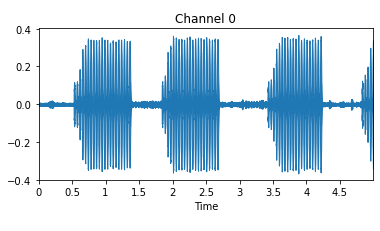

In [ ]:
# print(f'Audio shape [channels, samples]: {sample.shape}')
# sample.show();

Each "burst" in the plot above is a cricket chirp. There are three full chirps and the early starts of a fourth chirp.

# Normalizing an audio waveform

The first step is normalizing the audio waveform itself. We give it a mean of zero and unit variance in the usual way: 

$$\text{normedAudio} = \frac{\text{audio} - mean(\text{audio})}{std(\text{audio})} $$

In [ ]:
# # normalize the waveform
# norm_sample = (sample - sample.mean()) / sample.std()

Let's check if the mean is roughly $0$ and the variance is roughly $1$:

In [ ]:
# # checking the mean
# print(f'Original audio mean:   {sample.mean()}')
# print(f'Normalized audio mean: {norm_sample.mean()}')

Original audio mean:   -1.781299215508625e-05
Normalized audio mean: 2.876160698495056e-10


In [ ]:
# # checking the standard deviation
# print(f'Original audio standard dev:   {sample.var()}')
# print(f'Normalized audio standard dev: {norm_sample.var()}')

Original audio standard dev:   0.008586421608924866
Normalized audio standard dev: 1.0


Success! The waveform is normalized.

For convenience later on, we define the `AudioNormalize` transform to normalize waveforms in a fastai training loop.

In [ ]:
# class AudioNormalize(Transform):
#     "Normalizes a single `AudioTensor`."
#     def encodes(self, x:AudioTensor): return (x-x.mean()) / x.std()

In [ ]:
# # checking if the Transform normalized the waveform
# wav_norm = AudioNormalize()
# norm_sample = wav_norm(sample)
# print(f'Audio mean after transform: {norm_sample.mean()}')
# print(f'Audio standard dev after transform: {norm_sample.var()}')

Audio mean after transform: 2.876160698495056e-10
Audio standard dev after transform: 1.0


# Extracting spectrograms from audio

The next step is to extract a spectrogram from the normalized audio. We can do this with the `AudioToSpec` class in fastaudio. This class takes an `AudioTensor` as input and, as we might expect, returns an `AudioSpectrogram`.

In [ ]:
# # create a fastaudio Transform to convert audio into spectrograms
# cfg = AudioConfig.BasicSpectrogram() # with default torchaudio parameters
# audio2spec = AudioToSpec.from_cfg(cfg)

# # extract the spectrogram
# spec = audio2spec(norm_sample)

The `show` method of the `AudioSpectrogram` is a great, quick way to plot the spectrogram.

Spectrogram shape [channels, bins, time_steps]: torch.Size([1, 201, 1103])


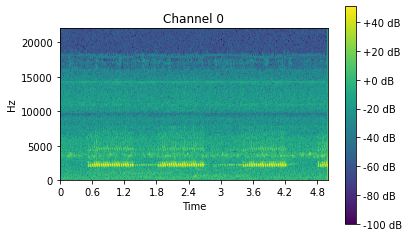

In [ ]:
# print(f'Spectrogram shape [channels, bins, time_steps]: {spec.shape}')
# spec.show();

The colorbar on the right showing the power in the signal is especially helpful since `matplotlib` always scales the values in a plot to the same color range. Without this colorbar, it is impossible to know or even guess the specific values in a spectrogram plot.

# Finding spectrogram normalization stats

To get the normalization stats, we have to step through the training set and find the mean and standard deviation of each mini-batch. Then we average all the mini-batch statistics to get a single pair of ($\mu,\sigma)$ normalization statistics. Note that normalization statistics must alway come from the training set. This is a crucial place to avoid data leakage.  

One small detail: if your training dataset is large enough it is not necessary to go through the whole set. Sampling 10% to 20% of the dataset can be enough for accurate statistics. However, since ESC-50 is small we find ($\mu,\sigma)$ from the whole set. 

To accumulate these statistics over mini-batches we can borrow and slightly refactor a class from this [very helpful post](http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html). The `StatsRecorder` class below tracks the mean and standard deviation across mini-batches.

In [ ]:
# class StatsRecorder:
#     def __init__(self, red_dims=(0,2,3)):
#         """Accumulates normalization statistics across mini-batches.
#         ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
#         """
#         self.red_dims = red_dims # which mini-batch dimensions to average over
#         self.nobservations = 0   # running number of observations

#     def update(self, data):
#         """
#         data: ndarray, shape (nobservations, ndimensions)
#         """
#         # initialize stats and dimensions on first batch
#         if self.nobservations == 0:
#             self.mean = data.mean(dim=self.red_dims, keepdim=True)
#             self.std  = data.std (dim=self.red_dims,keepdim=True)
#             self.nobservations = data.shape[0]
#             self.ndimensions   = data.shape[1]
#         else:
#             if data.shape[1] != self.ndimensions:
#                 raise ValueError('Data dims do not match previous observations.')
            
#             # find mean of new mini batch
#             newmean = data.mean(dim=self.red_dims, keepdim=True)
#             newstd  = data.std(dim=self.red_dims, keepdim=True)
            
#             # update number of observations
#             m = self.nobservations * 1.0
#             n = data.shape[0]

#             # update running statistics
#             tmp = self.mean
#             self.mean = m/(m+n)*tmp + n/(m+n)*newmean
#             self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
#                         m*n/(m+n)**2 * (tmp - newmean)**2
#             self.std  = torch.sqrt(self.std)
                                 
#             # update total number of seen samples
#             self.nobservations += n

By default `StatsRecorder` averages over the image channel dimensions (grayscale or RGB). The `red_dims` argument might look familiar from normalization code in other Computer Vision tasks (also the `Normalize` in fastai).  
To average over spectrogram channels instead we only need to pass a different `red_dims`. 

## Building the dataset loader

The setup below follows the fastaudio ESC-50 baseline to step through the training dataset. 
It is worth mentioning that the files in ESC-50 are sampled 44.1 kHz, but fastaudio will resample them to 16 kHz by default. Downsampling like this risks throwing away some information. But, keeping the higher sampling rate almost triples the "width" (aka time) of the spectrogram. This larger image will take up more memory in the GPU and limits our batch size and architecture choices. We keep this downsampling since it gives the spectrograms a very reasonable shape of `[201, 401]`, compared with the much larger shape of `[201, 1103]` if we don't downsample.

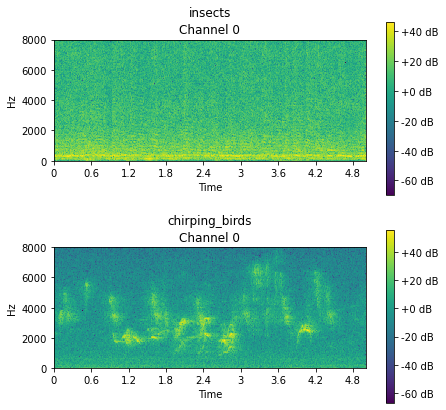

In [ ]:
# def CrossValidationSplitter(col='fold', fold=1):
#     "Split `items` (supposed to be a dataframe) by fold in `col`"
#     def _inner(o):
#         assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
#         col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
#         valid_idx = (col_values == fold).values.astype('bool')
#         return IndexSplitter(mask2idxs(valid_idx))(o)
#     return _inner

# auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
#                  get_x=ColReader("filename", pref=path/"audio"), 
#                  splitter=CrossValidationSplitter(fold=1),
#                  item_tfms = [AudioNormalize],
#                  batch_tfms = [audio2spec],
#                  get_y=ColReader("category"))
# dbunch = auds.dataloaders(df, bs=64)
# dbunch.show_batch(figsize=(7,7))

## Calculating the statistics

Next we make two recorders: one for global statistics and the other for channel-based statistics. Then we step through the training dataset to find both sets of stats.

In [ ]:
# # create recorders
# global_stats  = StatsRecorder()
# channel_stats = StatsRecorder(red_dims=(0,1,3))

# # step through the training dataset
# with torch.no_grad():
#     for idx,(x,y) in enumerate(iter(dbunch.train)):
#         # update normalization statistics
#         global_stats.update(x)
#         channel_stats.update(x)
    
# # parse out both sets of stats
# global_mean,global_std = global_stats.mean,global_stats.std
# channel_mean,channel_std = channel_stats.mean,channel_stats.std

We can check the shape of the statistics to make sure they are correct. For the global statistics, we expect a shape of: `[1,1,1,1]`. With spectrogram channel normalizations, we expect one value per spectrogram bin for a shape of `[1,1,201,1]`.

In [ ]:
# print(f'Shape of global mean: {global_mean.shape}')
# print(f'Shape of global standard dev: {global_std.shape}')

Shape of global mean: torch.Size([1, 1, 1, 1])
Shape of global standard dev: torch.Size([1, 1, 1, 1])


In [ ]:
# print(f'Shape of channel mean: {channel_mean.shape}')
# print(f'Shape of channel standard dev: {channel_std.shape}')

Shape of channel mean: torch.Size([1, 1, 201, 1])
Shape of channel standard dev: torch.Size([1, 1, 201, 1])


# Training with normalizations

Now for the moment of truth. We train with the two different spectrogram normalizations and measure their impact. For this we again follow the fastaudio baseline and train each type of normalization for 20 epochs. The final score is the averaged accuracy of five runs.

In [ ]:
# epochs = 20
# num_runs = 5

## `Transforms` to normalize mini-batches

We need to extend the fastai `Normalize` class in order to use the spectrogram normalization statistics. The reason is type dispatch. fastai normalization uses ImageNet statistics due to the focus on transfer learning with color images. But this ImageNet normalization is only applied on RGB images of the `TensorImage` class, while `AudioSpectrogram` subclasses the different `TensorImageBase`. The solution is to define `encodes` and `decodes` for `TensorImageBase` instead.

In [ ]:
# class SpecNormalize(Normalize):
#     "Normalize/denorm batch of `TensorImage`"
#     def encodes(self, x:TensorImageBase): return (x-self.mean) / self.std
#     def decodes(self, x:TensorImageBase):
#         f = to_cpu if x.device.type=='cpu' else noop
#         return (x*f(self.std) + f(self.mean))

In [ ]:
# # make global and channel normalizers
# GlobalSpecNorm  = SpecNormalize(global_mean,  global_std,  axes=(0,2,3))
# ChannelSpecNorm = SpecNormalize(channel_mean, channel_std, axes=(0,1,3))

## Training helpers  

To avoid repeating ourselves, the helper functions below build the dataloaders and run the training loops.  
The `get_dls` function makes it clear which normalization is being applied. The `train_loops` function repeats training runs a given number of times.

In [ ]:
# def get_dls(bs=64, item_tfms=[], batch_tfms=[]):
#     "Get dataloaders with given `bs` and batch/item tfms."
#     auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
#                      get_x=ColReader("filename", pref=path/"audio"), 
#                      splitter=CrossValidationSplitter(fold=1),
#                      item_tfms=item_tfms,   # for waveform normalization
#                      batch_tfms=batch_tfms, # for spectrogram normalization
#                      get_y=ColReader("category"))
#     dls = auds.dataloaders(df, bs=bs)
#     return dls

# def make_xresnet_grayscale(model, n_in=1):
#     "Modifies xresnet `model` for single-channel images." 
#     model[0][0].in_channels = n_in
#     # sum weights to reduce dimension
#     model[0][0].weight = torch.nn.parameter.Parameter(model[0][0].weight.mean(1, keepdim=True))

# def train_loops(dls, name, num_runs=num_runs, epochs=epochs, num_cls=50):
#     "Runs `num_runs` training loops with `dls` for given `epochs`."
#     accuracies = []
#     for i in range(num_runs):
#         # make new grayscale xresnet
#         model = xresnet18(pretrained=False, n_out=num_cls)
#         make_xresnet_grayscale(model, n_in=1)
#         # get learner for this run
#         learn = Learner(dls, model, metrics=[accuracy])
#         # train network and track accuracy
#         learn.fit_one_cycle(epochs)
#         accuracies.append(learn.recorder.values[-1][-1])
#     print(f'Average accuracy for "{name}": {sum(accuracies) / num_runs}')

## Baseline performance  

Before getting carried away with normalization, we have to first set a baseline without normalizations. This allows us to evaluate the impact of normalization later on, else there is no way to know if normalization helps at all.

In [ ]:
# # data without normalization
# dls = get_dls(batch_tfms=[audio2spec])
# # run training loops
# train_loops(dls, name='No Norm')

epoch,train_loss,valid_loss,accuracy,time
0,3.969248,3.820465,0.047500,00:12
1,3.712643,3.445267,0.117500,00:10
2,3.441750,3.214144,0.135000,00:10
3,3.175456,2.874947,0.237500,00:10
4,2.918222,2.914521,0.257500,00:10
5,2.663215,2.555236,0.267500,00:10
6,2.407773,2.380169,0.367500,00:10
7,2.180136,2.734919,0.350000,00:10
8,1.932248,2.028967,0.440000,00:10
9,1.694431,2.054369,0.435000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,4.095797,3.869291,0.050000,00:10
1,3.801821,3.425221,0.117500,00:10
2,3.496061,3.167158,0.185000,00:10
3,3.199899,3.019003,0.175000,00:10
4,2.915351,2.768171,0.252500,00:10
5,2.640109,2.538733,0.312500,00:10
6,2.361073,2.282025,0.357500,00:10
7,2.088267,2.159701,0.420000,00:10
8,1.831442,1.913155,0.457500,00:10
9,1.597652,1.653123,0.532500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.971367,3.820944,0.067500,00:10
1,3.723815,3.436206,0.102500,00:10
2,3.439669,3.116783,0.182500,00:10
3,3.146865,2.959616,0.182500,00:10
4,2.867068,3.017721,0.227500,00:10
5,2.587413,2.564640,0.297500,00:10
6,2.331449,2.480428,0.370000,00:10
7,2.083794,2.047217,0.430000,00:10
8,1.853696,1.991711,0.400000,00:10
9,1.636101,1.766080,0.475000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.994381,3.816283,0.040000,00:10
1,3.751954,3.452930,0.100000,00:10
2,3.493272,3.175919,0.155000,00:10
3,3.209845,3.087182,0.187500,00:10
4,2.924385,2.775273,0.195000,00:10
5,2.629113,2.482365,0.307500,00:10
6,2.349416,2.483069,0.332500,00:10
7,2.091504,2.187751,0.367500,00:10
8,1.825146,2.021458,0.457500,00:10
9,1.585074,1.668301,0.505000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,4.050342,3.846032,0.065000,00:10
1,3.785083,3.463626,0.115000,00:10
2,3.504684,3.193883,0.155000,00:11
3,3.218580,3.018942,0.177500,00:10
4,2.920237,2.771982,0.217500,00:11
5,2.635390,2.622943,0.300000,00:10
6,2.387567,2.534594,0.315000,00:10
7,2.146565,2.396223,0.352500,00:11
8,1.926011,1.926806,0.437500,00:10
9,1.686316,1.878930,0.475000,00:10


Average accuracy for "No Norm": 0.7110000014305115


## Performance with global normalization 
Next we normalize each audio waveform and the spectrograms with global, scalar statistics. 

In [ ]:
# # data with waveform and global normalization
# dls = get_dls(item_tfms=[AudioNormalize],
#               batch_tfms=[audio2spec, GlobalSpecNorm])
# # run training loops
# train_loops(dls, name='Global Norm')

epoch,train_loss,valid_loss,accuracy,time
0,4.026500,4.044263,0.032500,00:10
1,3.786512,3.503887,0.105000,00:10
2,3.517005,3.151405,0.197500,00:10
3,3.212996,2.836708,0.217500,00:11
4,2.892882,2.597347,0.260000,00:10
5,2.568272,2.591951,0.292500,00:10
6,2.249284,2.132349,0.402500,00:11
7,1.986435,2.256171,0.377500,00:10
8,1.719509,1.995517,0.440000,00:10
9,1.473958,1.578709,0.545000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,4.015247,4.054859,0.015000,00:10
1,3.765068,3.477965,0.112500,00:10
2,3.489605,3.153201,0.212500,00:10
3,3.185047,2.838492,0.210000,00:10
4,2.876298,3.269031,0.187500,00:10
5,2.564873,2.569763,0.287500,00:10
6,2.283852,2.240474,0.417500,00:10
7,2.036773,2.255483,0.332500,00:10
8,1.768668,1.871785,0.510000,00:10
9,1.535749,1.944937,0.505000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,4.009436,4.171368,0.025000,00:10
1,3.771747,3.559254,0.082500,00:10
2,3.491799,3.139065,0.152500,00:10
3,3.189236,2.902275,0.212500,00:10
4,2.851417,2.510654,0.320000,00:10
5,2.535454,2.469320,0.325000,00:10
6,2.232145,2.299582,0.405000,00:10
7,1.960728,2.387277,0.402500,00:10
8,1.700888,1.779266,0.505000,00:10
9,1.472246,1.544506,0.550000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,4.062994,4.126382,0.022500,00:10
1,3.816543,3.583234,0.100000,00:10
2,3.538556,3.187394,0.175000,00:10
3,3.237335,2.953974,0.200000,00:10
4,2.950168,2.901750,0.220000,00:10
5,2.663354,2.498471,0.340000,00:10
6,2.388274,2.204422,0.435000,00:11
7,2.118268,2.354115,0.415000,00:10
8,1.855800,1.905706,0.502500,00:10
9,1.604701,1.698043,0.517500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,4.028913,4.233477,0.040000,00:10
1,3.771104,3.508428,0.075000,00:10
2,3.471879,3.133292,0.172500,00:10
3,3.169908,3.090198,0.185000,00:10
4,2.840620,2.754784,0.265000,00:10
5,2.521406,2.394690,0.367500,00:10
6,2.214809,2.023241,0.485000,00:10
7,1.920039,1.977669,0.432500,00:10
8,1.659176,1.723857,0.557500,00:10
9,1.427005,1.615716,0.555000,00:10


Average accuracy for "Global Norm": 0.7315000057220459


## Performance with channel normalization  
Finally, we normalize each audio waveform and the spectrograms with channel-based statistics.  

In [ ]:
# # get data with waveform and channel normalization
# dls = get_dls(item_tfms=[AudioNormalize],
#               batch_tfms=[audio2spec, ChannelSpecNorm])
# # run training loops
# train_loops(dls, name='Channel Norm')

epoch,train_loss,valid_loss,accuracy,time
0,3.969699,4.032131,0.017500,00:10
1,3.730814,3.499502,0.077500,00:10
2,3.474650,3.243829,0.172500,00:10
3,3.231099,3.049371,0.205000,00:10
4,2.968587,3.039508,0.195000,00:10
5,2.697122,2.456799,0.325000,00:10
6,2.433818,2.410477,0.355000,00:10
7,2.190638,2.454575,0.342500,00:10
8,1.952075,1.899792,0.472500,00:10
9,1.715165,1.893039,0.502500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,4.054279,4.112432,0.030000,00:11
1,3.770565,3.521419,0.097500,00:10
2,3.469904,3.091036,0.172500,00:11
3,3.143619,2.904781,0.240000,00:11
4,2.809256,2.658845,0.275000,00:11
5,2.500878,2.275773,0.407500,00:11
6,2.210242,2.663011,0.307500,00:11
7,1.944063,2.182807,0.405000,00:11
8,1.715874,1.783302,0.492500,00:11
9,1.494896,1.829541,0.505000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,4.000810,4.160871,0.035000,00:12
1,3.732802,3.468769,0.092500,00:13
2,3.454084,3.086493,0.182500,00:14
3,3.150999,3.153290,0.195000,00:25
4,2.848003,2.756796,0.255000,00:49
5,2.549159,2.368085,0.382500,01:09
6,2.252295,2.275773,0.370000,01:06
7,1.985005,1.918476,0.462500,00:21
8,1.751421,2.049885,0.470000,00:18
9,1.527885,1.697186,0.520000,00:18


epoch,train_loss,valid_loss,accuracy,time
0,3.918051,4.025037,0.042500,00:37
1,3.684587,3.529938,0.067500,01:00
2,3.419808,3.125223,0.182500,00:45
3,3.131472,3.015343,0.175000,00:40
4,2.819206,2.528827,0.300000,00:25
5,2.517766,2.448646,0.317500,00:13
6,2.233410,2.906568,0.247500,00:11
7,1.965338,2.038978,0.430000,00:11
8,1.724016,1.756567,0.517500,00:11
9,1.485556,2.177741,0.477500,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.953691,4.050189,0.030000,00:10
1,3.683712,3.337167,0.132500,00:11
2,3.373129,3.000274,0.215000,00:10
3,3.073662,2.747640,0.247500,00:11
4,2.768026,2.885627,0.215000,00:11
5,2.473330,2.373895,0.375000,00:11
6,2.200260,2.475523,0.372500,00:10
7,1.933803,1.945074,0.467500,00:11
8,1.697937,1.811188,0.522500,00:11
9,1.477577,2.002481,0.495000,00:11


Average accuracy for "Channel Norm": 0.7144999861717224


# Discussion

The results are:  

| Normalization | Average Accuracy |
| :---: | :---: |
| None | .7110 |
| Global | **.7315** |
| Channel | .7144 |


I ran the cells above several times to make sure these patterns held. Overall, there is a gain from global normalization. Channel-based normalization shows a smaller benefit. While these increases in performance are a good starting point, there are several explanations for this that point us towards other approaches.

For starters, the spectrograms in ESC-50 are very different both within and across classes. In other words the activity in each spectrogram channel changes a lot from sample to sample. A global statistic likely fares better under these unpredictable conditions. If all the audio came from a similar source, like speech, then the per-channel normalization might fare better.  

We also process the entire five second files at once, which is a large analysis window by audio standards. This large window means that each sample looks exactly the same in every epoch. If we used a smaller analysis window, say 2 seconds, we could randomly "crop" many spectrogram regions from a single example as a kind of data augmentation. The risk here is grabbing a silent region without any information but still giving it a class label (though an energy threshold can prevent this). Cropping with a smaller analysis window is one way to expose the networks to more samples and variability. 

Using the entire waveform at once also means that the waveform statistics need to model a very long-term relationship. Going back to the cricket recording example: we would not expect good normalization statistics for the chirps to be the same as good statistics for the pauses in between chirps. To counter this it is possible to do a "short-time" normalization. Here we pick a sliding window, often much smaller than the whole waveform, and only normalize the data inside as it steps through the waveform. This "short-time" normalization can be applied with or without the global waveform normalization. 

Furthermore, the spectrogram is a high-dimensional feature with 201 frequency bins. It is common in audio tasks to reduce this dimension by combining nearby bins. This is done with something called "filterbanks" which usually operate at the Mel frequency scale. [This tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) is one of my favorites and gives an incredibly clear description of Mel frequency and the filterbank process. There are other options such as [Gammatone filterbanks](https://www.mathworks.com/help/audio/ref/gammatonefilterbank-system-object.html) as well. While this might seem like an expert handcrafted feature, there is good reason for using filterbanks in audio tasks. If we feed in a raw spectrogram, the early convolutional layers tend to learn something like a filterbank anyway! So directly feeding a filterbank into the network lets it focus on more complicated relationships. As a bonus, the channel-based normalization discussed here also works on filterbank features.

We are also training a powerful 18-layer model from scratch with only 1600 images. While deep learning can handle datasets this small, it is usually only through Transfer Learning. But, we stayed away from Transfer Learning because pretrained networks are tightly coupled to their original dataset's normalization statistics. And the main idea here was to learn our own spectrogram scalings. It is possible that a smaller, simpler network will perform better. Looking at the training logs above, it seems the validation loss was still decreasing. So we'd still have to train for longer to check if the network is actually overfitting and a simpler model is needed.  

Lastly, there is no data augmentation even though it is almost de facto when training CNNs. It is possible to use image augmentations (flips, rotations, etc) even though they do not technically make sense on a spectrogram. It might be better to use augmentations directly inspired by signal processing like [`SpecAugment`](https://arxiv.org/abs/1904.08779). By the way, `SpecAugment` is already included in fastaudio! Along with many other waveform and spectrogram [augmentations](https://github.com/fastaudio/fastaudio/tree/master/src/fastaudio/augment). 

To recap, there are many good reasons why normalization only helped a little on the ESC-50 dataset. The points above described some possible next steps to increase performance.


# Conclusions

In this post we saw how spectrograms are fundamentally different than natural images. We then explored two ways of normalizing spectrograms when training neural networks: global normalization and channel-based normalization.  

Next we implemented these two normalization techniques and tested them against an unnormalized baseline on the ESC-50 dataset. Both normalizations showed a gain in performance, with global normalization outperforming channel-based normalization. We then offered some next steps that could further boost performance.  

In the end, the choice of spectrogram normalization will depend on how the system is used. For example, if the system will be deployed in an environment similar to the training environment, then normalizing by spectrogram channels makes more sense. This is because the training statistics will be a good match for the similar patterns and distributions in the deployed environment. However, it is critical to monitor the system in this environment and update the statistics as needed to avoid shifting out of domain.  

If the system will instead be used in a completely different environment, of which you have no knowledge, then the global statistics could be a better fit. While not as technically sound, the model will (hopefully) be less surprised by radically new activity across the channels. 

To recap, there is no one universally correct way to normalize spectrograms for every audio task. Like many aspects of deep learning, the final choice will be experimental and based on the specifics of both the problem and domain.  

I hope this post gave you an idea of how to normalize spectrograms. Even moreso, I hope that it gave you new ideas to try out. The ESC-50 is a great playground for any new ideas. Happy experimenting!

#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| hide
from nbdev.showdoc import *